# Setup

**Imports**

In [6]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import ruptures as rpt
from math import asin, cos, radians, sin, sqrt
import contextily as cx

rng = np.random.default_rng()

from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs
import geopandas
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

import datetime as dt
from math import log
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from matplotlib.dates import DateFormatter
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.dates import DateFormatter
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind
from scipy.optimize import minimize

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

Design a procedure that takes a sound signal as input and outputs the sequence of symbols. To
that end, you can use the provided training set. The signals have a varying number of symbols
with a varying duration. There is a brief silence between each symbol.

Describe in 5 to 10 lines your methodology and the calibration procedure (give the hyperparameter values). Hint: use the time-frequency representation of the signals, apply a change-point
detection algorithm to find the starts and ends of the symbols and silences, and then classify each
segment.

First we apply a ... to our signals to get a time-frequency representation of them. 
As we know there is a silence between each symbol, we can apply a change point detection to locate each symbol. 
The change points detected wilh correspond to a slice of our signals with one piece = one symbol 
We then use a supervised classification algorithm to map piece-signal to corresponding symbol

In [7]:
touches = [
    ["1", "2", "3", "A"],
    ["4", "5", "6", "B"],
    ["7", "8", "9", "C"],
    ["*", "0","#","D"],
]

In [8]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [9]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


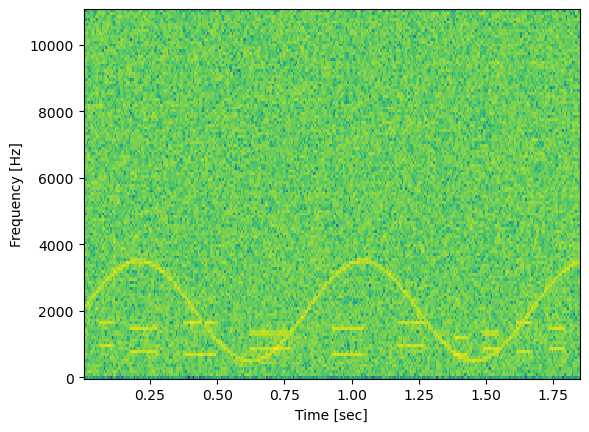

In [10]:
#get spectrogram of signal
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(signal, fs=FS, nperseg=256, noverlap=128)
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.show()


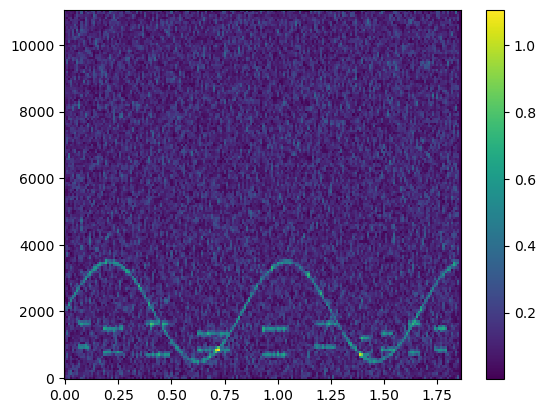

In [11]:
f, t, Zxx = scipy.signal.stft(signal, fs = FS, noverlap=100, nperseg=312,padded=True)
plt.pcolormesh(t,f, np.abs(Zxx))
plt.colorbar()
plt.show()

c:\Users\grego\miniconda3\envs\map588\lib\site-packages\pywt\_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


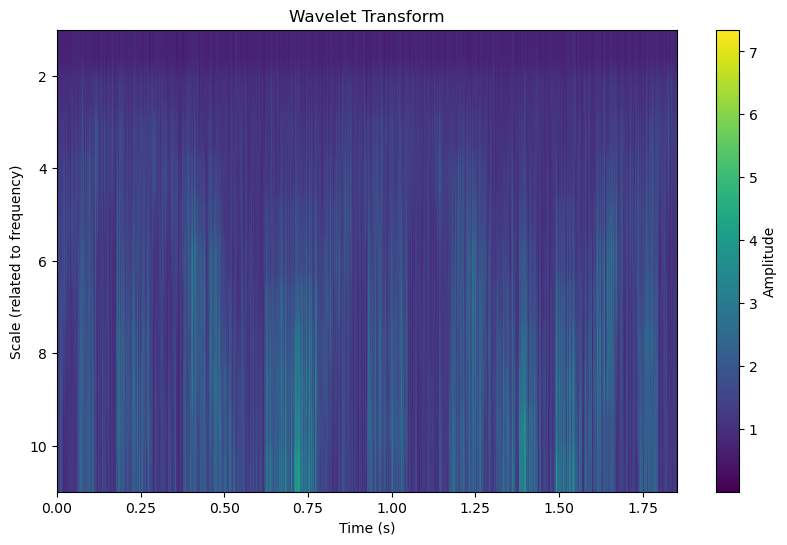

In [12]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Define scales and wavelet for Continuous Wavelet Transform
scales = np.arange(1, FS/2000)  # Adjust scale range as needed
wavelet = 'cmor'  # Continuous wavelet, you can use 'cmor', 'mexh', etc.

# Perform the Continuous Wavelet Transform
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=1/FS)

# Plot the wavelet transform
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), extent=[0, len(signal)/FS, scales[-1], scales[0]],
           cmap='viridis', aspect='auto')
plt.colorbar(label="Amplitude")
plt.title("Wavelet Transform")
plt.xlabel("Time (s)")
plt.ylabel("Scale (related to frequency)")
plt.show()


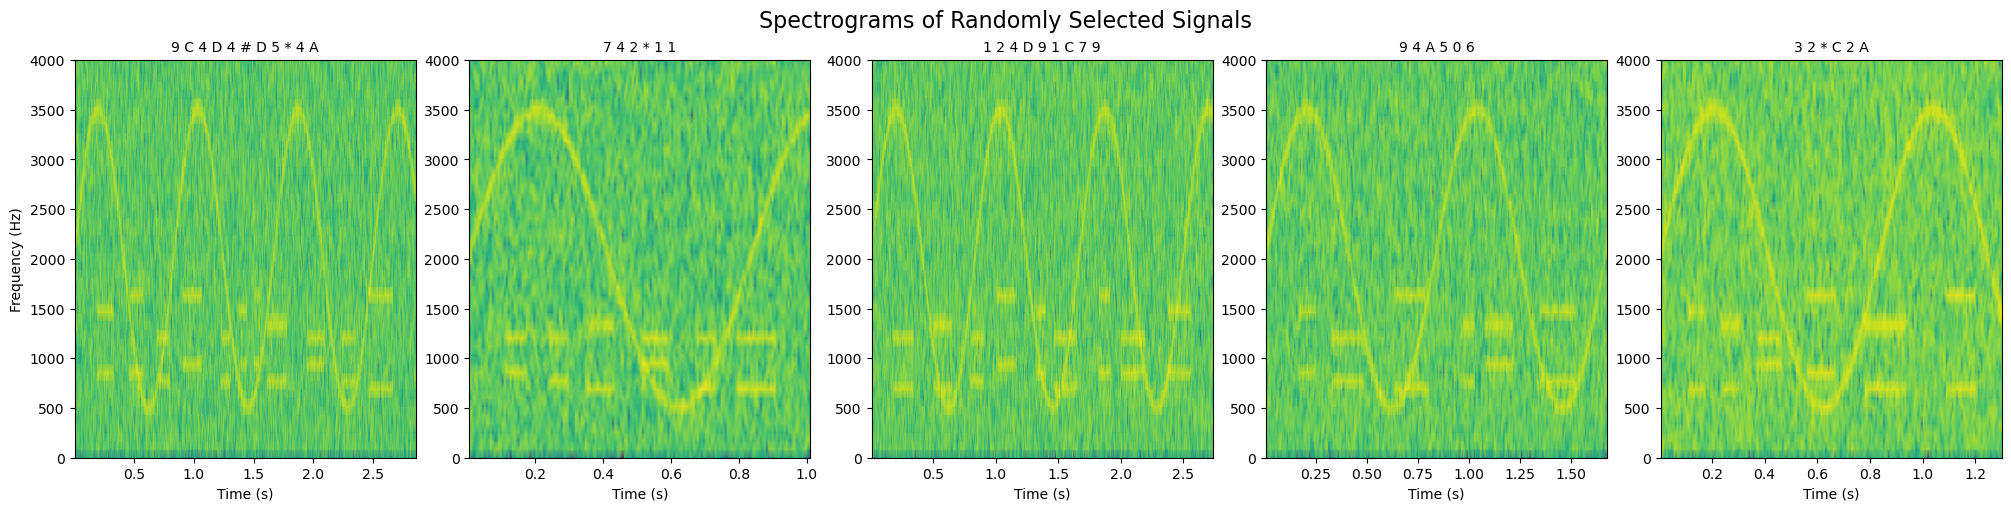

In [13]:
# Randomly select 5 indices from the training set
random_indices = np.random.choice(len(X_train), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

for i, idx in enumerate(random_indices):
    signal = X_train[idx]
    symbols = y_train[idx]
    
    # Compute spectrogram
    f, t, Sxx = spectrogram(signal, fs=FS, nperseg=256, noverlap=128)
    
    # Plot the spectrogram
    ax = axes[i]
    ax.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='viridis', shading='gouraud')
    ax.set_title(f"{' '.join(symbols)}", fontsize=10)
    ax.set_xlabel("Time (s)")
    if i == 0:
        ax.set_ylabel("Frequency (Hz)")
    ax.set_ylim(0, 4000)  # Focus on 0-4000 Hz

plt.suptitle("Spectrograms of Randomly Selected Signals", fontsize=16)
plt.show()


We recognize well the symbols on the spectrograms. 
We have the right number of symbols each time, and for each signals, we recognize the two frequencies. 
The big cosinus through the spectrograms suggest the presence of a periodic signal with a very low frequency. 
We could maybe try to get rid of it as we know it does not correspond to any symbol nor signal and might thus impair our change point analysis.
We can use for that a filtre passe-haut

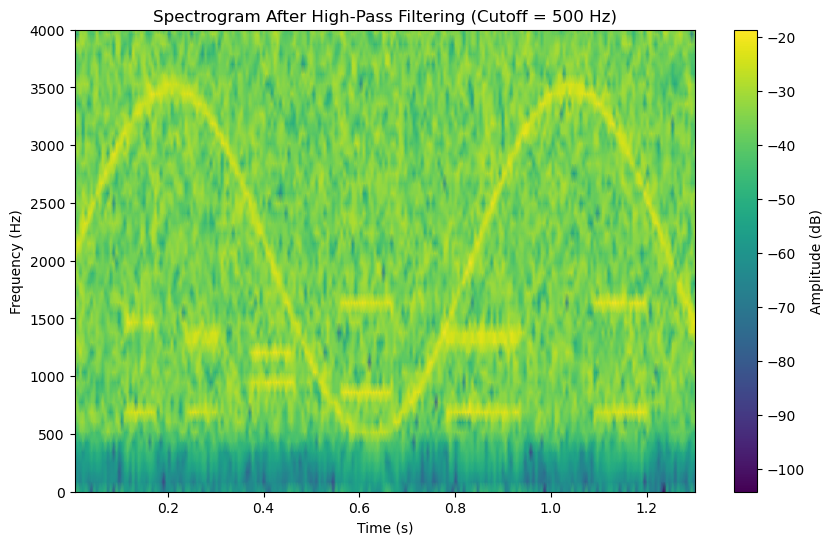

In [14]:
from scipy.signal import butter, filtfilt, spectrogram
import matplotlib.pyplot as plt
import numpy as np

# Define the high-pass filter
def high_pass_filter(signal, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply high-pass filter (cutoff = 500 Hz)
cutoff_freq = 500  # 500 Hz
filtered_signal = high_pass_filter(signal, cutoff=cutoff_freq, fs=FS)

# Generate the spectrogram for the filtered signal
f, t, Sxx = spectrogram(filtered_signal, fs=FS, nperseg=256, noverlap=128)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='viridis', shading='gouraud')
plt.colorbar(label='Amplitude (dB)')
plt.title(f"Spectrogram After High-Pass Filtering (Cutoff = {cutoff_freq} Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 4000)  # Focus on 0-2000 Hz
plt.show()


Then we want to do penalized change point detection : the number of change point is unknown 

In [15]:
#filter the cosine signal
std_signal = np.std(signal)
print(f"Standard deviation of the original signal: {std_signal:.2f}")

Standard deviation of the original signal: 2.23


In [16]:
n_samples = len(signal)
noise_std = 0.1 * std_signal  # 10% of the signal's standard deviation

## Method with known number of breakpoints

In [17]:
#fonction to get change points and corresponding frequencies
def get_change_point_and_freq(signal, symbols):
    # Compute spectrogram
    f, t, Sxx = spectrogram(signal, fs=FS, nperseg=256, noverlap=128)

    # Select a specific frequency band or summarize
    freq_band = (500, 2000)  # Focus on 500-2000 Hz
    freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
    spectrogram_band = Sxx[freq_mask, :]  # Select power in the frequency band

    # Aggregate across the frequency band (e.g., sum or mean)
    time_series = np.mean(spectrogram_band, axis=0)

    # Apply the PELT algorithm to the time series
    #VERSION 1
    #algo = rpt.Pelt(model="rbf").fit(time_series)
    #change_points = algo.predict(pen=3)
    
    #VERSION 2 : nb of cp known
    algo = rpt.Dynp(model='l2').fit(time_series)
    change_points = algo.predict(n_bkps=len(symbols)*2)
    
    res = []
    #compute histogram for each change segment, argsort and take top 2 
    for i in range(len(change_points)-1):
        if i%2 == 0: 
            segment = spectrogram_band[:, change_points[i]:change_points[i + 1]]
            #segment = segment.flatten()
            
            # Calculer la puissance moyenne pour chaque fréquence
            mean_power = np.mean(segment, axis=1)
    
            # Identifier les deux fréquences principales
            top_indices = np.argsort(mean_power)[-2:]  # Indices des 2 plus grandes puissances
            top_frequencies = f[top_indices]  # Fréquences correspondantes
            top_frequencies = np.sort(top_frequencies)  # Trier les fréquences croissantes
            
            #hist, bin_edges = np.histogram(segment, bins=150)

            #bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            

            #top_indices = np.argsort(hist)[-2:]  # Indices of top 2 bins
            #top_frequencies = np.sort(bin_centers[top_indices])
            res.append(top_frequencies)
            
    return [t[cp] for cp in change_points if cp < len(t)], res

134
[15, 30, 45, 55, 65, 80, 100, 115, 134]


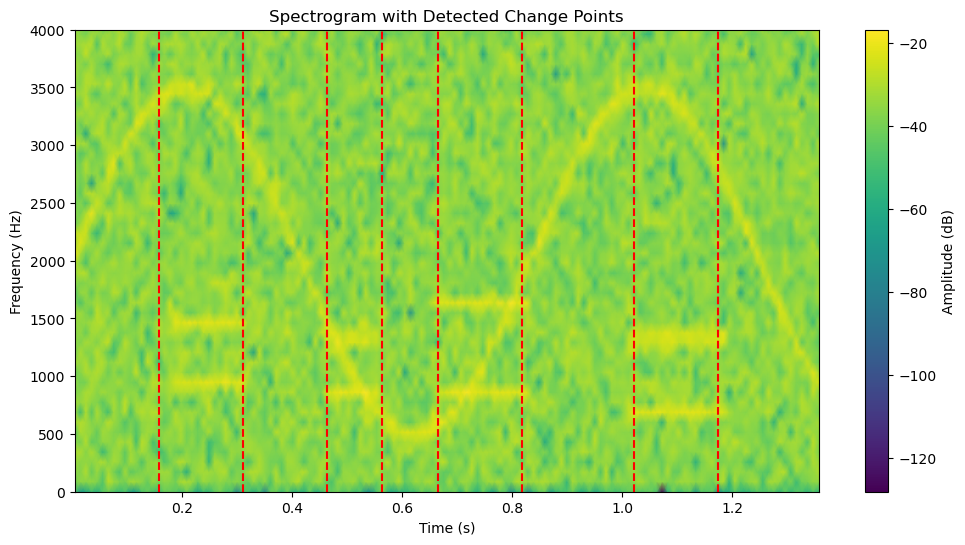

In [18]:
#random_indices = np.random.choice(len(X_train), 5, replace=False)
signal = X_train[67]
symbols = y_train[67]

# Compute spectrogram
f, t, Sxx = spectrogram(signal, fs=FS, nperseg=256, noverlap=256//8)
print(len(t))
# Select a specific frequency band or summarize
freq_band = (500, 2000)  # Focus on 500-2000 Hz
freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
spectrogram_band = Sxx[freq_mask, :]  # Select power in the frequency band

# Aggregate across the frequency band (e.g., sum or mean)
time_series = np.mean(spectrogram_band, axis=0)

# Apply the PELT algorithm to the time series
algo = rpt.Pelt(model="rbf").fit(time_series)
change_points = algo.predict(pen=3)
print(change_points)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
from scipy.ndimage import gaussian_filter

noise_threshold = -25
Sxx_cleaned = np.where(Sxx < noise_threshold, noise_threshold, Sxx)

plt.pcolormesh(t, f, 10 * np.log10(Sxx_cleaned), cmap='viridis', shading='gouraud')
plt.colorbar(label='Amplitude (dB)')
plt.title("Spectrogram with Detected Change Points")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 4000)  # Focus on lower frequencies

# Overlay detected change points
for cp in change_points:
    if cp < len(t):
        plt.axvline(t[cp], color="red", linestyle="--", label="Change Point")
    #plt.axvline(t_adjusted[cp], color="red", linestyle="--", label="Change Point")

#plt.legend()
plt.show()


In [19]:
#create list of symbols
symbols = set()
for y in y_train: 
    for symbol in y:
        if symbol not in symbols:
            symbols.add(symbol)
symbols = list(symbols)

#learn dictionnary
dico= {symbols[i]: [] for i in range(len(symbols))}

for signal, sym in zip(X_train, y_train):
    #time_cp, res = get_change_point_and_freq(signal, sym)
    time_cp, res = get_change_point_and_freq(signal, sym)
    print(res)
    print(len(sym))
    for i, s in enumerate(sym): 
        #dans dico de s on ajoute les deux fréquences résultats
        print(i,s)
        if i < len(res):
            dico[s].append(res[i])
            

dico_mean = {
    key: [np.median(np.array(values).T[0]), np.median(np.array(values).T[1])] for key, values in dico.items()
}

def get_symbol(res, my_dico):
    dico_keys = list(my_dico.keys())
    dico_values = np.array(list(my_dico.values()))  # Shape: (n_symbols, 2)

    res_array = np.array(res)  # Shape: (n_samples, 2)
    freq_diff = res_array[:, None, :] - dico_values[None, :, :]  # Shape: (n_samples, n_symbols, 2)
    squared_errors = np.sum(freq_diff**2, axis=2)  # Shape: (n_samples, n_symbols)

    min_indices = np.argmin(squared_errors, axis=1)  # Shape: (n_samples,)
    symbols = [dico_keys[i] for i in min_indices]

    return symbols

[array([258.3984375, 861.328125 ]), array([ 947.4609375, 1119.7265625]), array([258.3984375, 516.796875 ])]
3
0 5
1 C
2 3
[array([344.53125 , 861.328125]), array([344.53125, 689.0625 ]), array([172.265625 , 258.3984375]), array([ 258.3984375, 1119.7265625]), array([258.3984375, 861.328125 ]), array([  0.      , 172.265625]), array([172.265625 , 947.4609375])]
7
0 8
1 7
2 C
3 B
4 5
5 A
6 3
[array([ 430.6640625, 1119.7265625]), array([258.3984375, 947.4609375]), array([ 172.265625 , 1119.7265625]), array([  0.     , 344.53125]), array([861.328125 , 947.4609375]), array([  0.     , 344.53125]), array([172.265625, 689.0625  ]), array([344.53125 , 861.328125]), array([ 258.3984375, 1119.7265625]), array([344.53125  , 947.4609375])]
10
0 D
1 6
2 A
3 8
4 3
5 D
6 1
7 8
8 B
9 9
[array([ 172.265625 , 1119.7265625]), array([430.6640625, 689.0625   ]), array([ 0.       , 86.1328125]), array([689.0625   , 947.4609375]), array([172.265625 , 258.3984375]), array([ 430.6640625, 1119.7265625]), array([

Pour chaque signal : 
- change points = indices des bars => idx of time of rupture
- parties du signal intéressantes signal[idx_pair, idx_pair+1] 0,1,2,3 4,5 etc 
- dessus on fait un argmax pour avoir les deux fréquences d'intéret 

=> infos collectées = idx des change points + les deux fréquences correspondantes 
=> on "match avec y_train" 
.....=> on crée un dico avec tous les symboles 
.....=> 
=> on map 

In [20]:
f1 = np.array([697, 770, 852, 941])
f2 = np.array([1209, 1336, 1477, 1633])

def predict_from_signal(
    signal: np.ndarray,
    nperseg: int = 512,
    noverlap: int = 6,
    min_size: int = 2,
    min_break_time: float = 0.2,
    min_energy: float = 0.1,
   
) :
  
    sigma = 1.6
    # Estimate penalty
    pen_bic = 0.001 * sigma**2 * np.log(len(signal))

    # Compute spectrogram
    f, t, Sxx = spectrogram(signal, FS, nperseg=nperseg, noverlap=noverlap)

    # Compute studied windows
    min_freq = 650
    max_freq = 1800
    idx_min_freq = np.argmin(np.abs(f - min_freq))
    idx_max_freq = np.argmin(np.abs(f - max_freq))

    # Compute minimum and maximum distance (in Hz) between 2 frequencies
    # Those are the min and max distances found in the DTMF
    min_freq_dist = 250
    max_freq_dist = 950

    # Initialize algorithm
    algo = rpt.Pelt(model="l1", jump=1, min_size=min_size)

    # Fit and predict on signal
    predicted_bkps = algo.fit_predict(signal=Sxx.T, pen=pen_bic)


    # We iterate every 2 breakpoints
    # Odd breakpoints show symbols, even breakponts show silences
    predictions_segments = []
    for idx_bkp in range(0, len(predicted_bkps[:-2]), 2):
        # define start and end time
        start_time = t[predicted_bkps[idx_bkp]]
        end_time = (
            t[predicted_bkps[idx_bkp + 1]]
            if predicted_bkps[idx_bkp + 1] < len(t)
            else t[-1]
        )

        # define zone in spectrogram
        Sxx_zone = Sxx[
            idx_min_freq:idx_max_freq,
            predicted_bkps[idx_bkp] : predicted_bkps[idx_bkp + 1],
        ]

        # find the 2 frequencies with maximum energy in the spectrogram
        energy = np.mean(Sxx_zone, axis=1)
        freqs = f[idx_min_freq + np.argsort(energy)[-2:]]

        # if the 2 found frequencies are too far aport, or not enough, we discard them
        if (
            np.abs(freqs[0] - freqs[1]) < min_freq_dist
            or np.abs(freqs[0] - freqs[1]) > max_freq_dist
        ):
            continue

        # compute the closest frequencies in the DTMF
        distances_f1 = np.min(
            np.abs(f1[:None, None] - freqs[None, None, :]), axis=(0, 2)
        )
        distances_f2 = np.min(
            np.abs(f2[:None, None] - freqs[None, None, :]), axis=(0, 2)
        )
        pred_f1 = np.argmin(distances_f1)
        pred_f2 = np.argmin(distances_f2)

        # save segment
        predictions_segments.append(
            {
                "freqs": freqs,
                "symbol": touches[pred_f1][pred_f2],
                "start_time": start_time,
                "end_time": end_time,
                "energy": np.sum(np.sort(energy)[-2:]) / (end_time - start_time),
            }
        )

    # merge segments if they are close and have the same symbol
    whitelisted_segments = [predictions_segments[0]]
    for idx, next_segment in enumerate(predictions_segments[1:]):
        if (
            next_segment["symbol"] == whitelisted_segments[-1]["symbol"]
            and next_segment["start_time"] - whitelisted_segments[-1]["end_time"]
            < min_break_time
        ):
            whitelisted_segments[-1]["end_time"] = next_segment["end_time"]
        else:
            whitelisted_segments.append(next_segment)

    # only keep segment with enough energy
    whitelisted_segments = [
        segment for segment in whitelisted_segments if segment["energy"] > min_energy
    ]

    predicted_symbols = [segment["symbol"] for segment in whitelisted_segments]
    return predicted_symbols

import Levenshtein
def accuracy_score(
    y_true, y_pred
):
    """Compute the accuracy score between a set of prediction a set of labels

    Args:
        y_true (Union[List[str], List[List[str]]]): List of true labels, eg ["B91", "CD"] or [["B", "9", "4"], ["C", "D"]]
        y_pred (Union[List[str], List[List[str]]]): List of predictions, eg ["B81", "CE"] or [["B", "8", "4"], ["C", "E"]]

    Returns:
        Tuple[float, float]: list of accuracies per label
    """
    accuracies = []
    for label, prediction in zip(y_true, y_pred):
        if isinstance(label, list):
            label = "".join(label)
        if isinstance(prediction, list):
            prediction = "".join(prediction)
        distance = Levenshtein.distance(prediction, label)
        accuracy = 1 - distance / max(len(label), len(prediction))
        accuracies.append(accuracy)
    accuracies = np.array(accuracies)
    return accuracies

In [21]:
predictions = [predict_from_signal(signal) for signal in X_train]
accuracies = accuracy_score(y_train, predictions)
print(
    "Accuracy score: {:.2f}% (+- {:.2f})".format(
        100 * np.mean(accuracies), 100 * np.std(accuracies)
    )
)

Accuracy score: 80.22% (+- 17.03)


# Question 2

In [22]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()


print('premier essai')
signal, symbols= X_test[0], y_test[0]
sound_1_symbols = predict_from_signal(X_test[0])
print('vraie valeur: ')

print(symbols)
print('prediction: ')
print(sound_1_symbols)
print()
print('deuxieme essai')

signal, symbols= X_test[1], y_test[1]
sound_2_symbols = predict_from_signal(X_test[1])
print('vraie valeur: ')
print(symbols)
print('prediction: ')
print(sound_2_symbols)

premier essai
vraie valeur: 
['7', '2', '1', 'C', '9', '9']
prediction: 
['7', '2', '1', 'C', '9', '9']

deuxieme essai
vraie valeur: 
['1', '#', '2', '#']
prediction: 
['1', '#', '2', '#']


# Question 3

In [23]:
# Parameters
lambda_n = 12  # Maximum eigenvalue
M = 9          # Number of scales
R_values = [1, 3, 5]  # Different R values to analyze
lambdas = np.linspace(-12, 12, 10000)  # Eigenvalue range

In [24]:
def g_hat_U(lambda_, a, R): 
    print()
    return 0.5 * (1 + np.cos(2 * np.pi * ((lambda_ / (a * R)) + 0.5))) * (lambda_ < 0) * (lambda_ >= -a * R)

def g_hat_m(lambda_, a, m, R): 
    return g_hat_U(lambda_ - a * m, a, R)

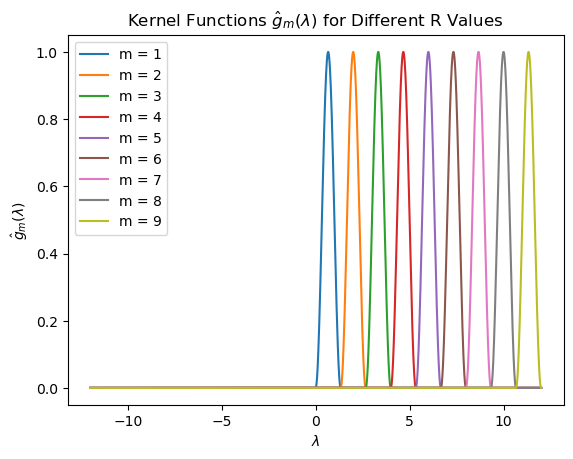

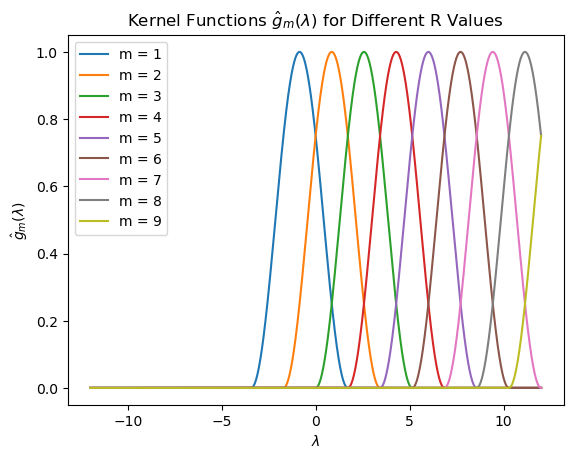

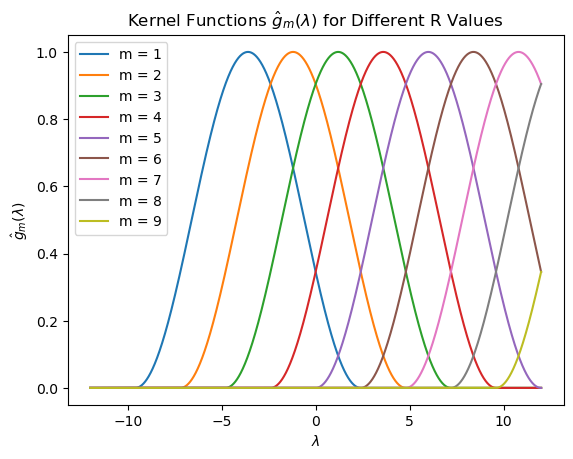

In [25]:
# Plot the kernel functions gˆm for R = 1, R = 3 and R = 5 (take λn = 12) 

for R in R_values:
    a = lambda_n / (M + 1 - R)
    for m in range(1,M+1):
        plt.plot(lambdas, g_hat_m(lambdas, a, m, R), label=f"m = {m}")
    plt.title("Kernel Functions $\\hat{g}_m(\\lambda)$ for Different R Values")
    plt.xlabel("$\\lambda$")
    plt.ylabel("$\\hat{g}_m(\\lambda)$")
    plt.legend()
    plt.show()


# Question 4

In [26]:
def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g


CRS = "EPSG:4326"

STATION_LIST = [
    "ARZAL",
    "AURAY",
    "BELLE ILE-LE TALUT",
    "BIGNAN",
    "BREST-GUIPAVAS",
    "BRIGNOGAN",
    "DINARD",
    "GUERANDE",
    "ILE DE GROIX",
    "ILE-DE-BREHAT",
    "KERPERT",
    "LANDIVISIAU",
    "LANNAERO",
    "LANVEOC",
    "LORIENT-LANN BIHOUE",
    "LOUARGAT",
    "MERDRIGNAC",
    "NOIRMOUTIER EN",
    "OUESSANT-STIFF",
    "PLEUCADEUC",
    "PLEYBER-CHRIST SA",
    "PLOERMEL",
    "PLOUDALMEZEAU",
    "PLOUGUENAST",
    "PLOUMANAC'H",
    "POMMERIT-JAUDY",
    "PONTIVY",
    "PTE DE CHEMOULIN",
    "PTE DE PENMARCH",
    "PTE DU RAZ",
    "QUIMPER",
    "QUINTENIC",
    "ROSTRENEN",
    "SAINT-CAST-LE-G",
    "SARZEAU SA",
    "SIBIRIL S A",
    "SIZUN",
    "SPEZET",
    "ST BRIEUC",
    "ST NAZAIRE-MONTOIR",
    "ST-SEGAL S A",
    "THEIX",
    "VANNES-SENE",
]

In [27]:
data_df, stations_df, description = load_molene_meteo_dataset()
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

In [28]:
data_df.head()

numer_sta                date         date_insert  td       t      tx  \
0   22016001 2014-01-01 00:00:00 2014-01-01 00:13:55 NaN  280.15  281.35   
1   22016001 2014-01-01 01:00:00 2014-01-01 01:07:59 NaN  280.15  280.25   
2   22016001 2014-01-01 02:00:00 2014-01-01 02:08:05 NaN  280.95  280.95   
3   22016001 2014-01-01 03:00:00 2014-01-01 03:08:09 NaN  281.45  281.45   
4   22016001 2014-01-01 04:00:00 2014-01-01 04:08:14 NaN  282.05  282.05   

       tn   u  ux  un  ...  vv  etat_sol  sss   n  insolh  ray_glo01  pres  \
0  280.15 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
1  279.65 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
2  280.15 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
3  280.95 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   
4  281.45 NaN NaN NaN  ... NaN       NaN  NaN NaN     0.0        0.0   NaN   

   pmer   station_name  temp  
0   NaN  ILE-DE-BREHAT   7.0  
1   NaN  ILE-DE-BREHAT   7.0  
2   NaN  ILE-DE-BREHAT   7.8  
3   NaN  ILE-DE-BREHAT   8.3  
4   NaN  ILE-DE-BREHAT   8.9  

[5 rows x 31 columns]

In [29]:
# pivot data_df to have multivariate time series
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
temperature_df.head()

station_name         ARZAL  AURAY  BATZ  BEG_MEIL  BELLE ILE-LE TALUT  BIGNAN  \
date                                                                            
2014-01-01 00:00:00    9.7   10.3   NaN       NaN                11.3     7.1   
2014-01-01 01:00:00    9.8   10.4   NaN       NaN                10.3     7.6   
2014-01-01 02:00:00    9.7   10.0   NaN       NaN                11.2     7.7   
2014-01-01 03:00:00    9.4   10.4   NaN       NaN                11.4     7.9   
2014-01-01 04:00:00    9.8   10.8   NaN       NaN                11.4     8.8   

station_name         BREST-GUIPAVAS  BRIGNOGAN  CAMARET  DINARD  ...  \
date                                                             ...   
2014-01-01 00:00:00             9.7        NaN      NaN     6.8  ...   
2014-01-01 01:00:00             9.6        9.2      NaN     6.5  ...   
2014-01-01 02:00:00             9.1        9.4      NaN     6.5  ...   
2014-01-01 03:00:00             9.7       10.1      NaN     7.1  ...   
2014-01-01 04:00:00             9.8       10.2      NaN     7.6  ...   

station_name         SIBIRIL S A  SIZUN  SPEZET  ST BRIEUC  \
date                                                         
2014-01-01 00:00:00          7.4    8.5     8.3        7.5   
2014-01-01 01:00:00          8.2    8.3     8.6        7.0   
2014-01-01 02:00:00          8.5    8.5     8.6        7.5   
2014-01-01 03:00:00          8.5    8.7     8.9        7.2   
2014-01-01 04:00:00          9.1    9.1     9.4        7.6   

station_name         ST NAZAIRE-MONTOIR  ST-SEGAL S A  THEIX  TREGUNC  \
date                                                                    
2014-01-01 00:00:00                 9.0           9.0    9.3     10.8   
2014-01-01 01:00:00                 9.1           9.5    9.1     10.9   
2014-01-01 02:00:00                 9.5           9.4    9.4     10.6   
2014-01-01 03:00:00                 9.0           9.9    8.9     10.8   
2014-01-01 04:00:00                 9.5          10.0    9.6     11.0   

station_name         VANNES-MEUCON  VANNES-SENE  
date                                             
2014-01-01 00:00:00            8.5          9.7  
2014-01-01 01:00:00            8.7          9.9  
2014-01-01 02:00:00            8.8          9.6  
2014-01-01 03:00:00            8.6          9.8  
2014-01-01 04:00:00            9.2         10.2  

[5 rows x 55 columns]

In [30]:
# extract names of stations with NA values
temp_na = temperature_df.isna().sum(axis=0).sort_values(ascending=False)
temp_na = temp_na[temp_na > 0]

# display stations with NaN values
temp_na.index.tolist()

['BATZ',
 'BEG_MEIL',
 'CAMARET',
 'PLOUGONVELIN',
 'RIEC SUR BELON',
 'ST NAZAIRE-MONTOIR',
 'PLOUAY-SA',
 'VANNES-MEUCON',
 'LANNAERO',
 'PLOUDALMEZEAU',
 'LANDIVISIAU',
 'SIZUN',
 'QUIMPER',
 'OUESSANT-STIFF',
 'LANVEOC',
 'ARZAL',
 'BREST-GUIPAVAS',
 'BRIGNOGAN']

In [31]:
station_names_with_nan = temp_na.index.tolist()

print(np.unique(station_names_with_nan))

#remove those stations from the data
data_df_clean = data_df[~data_df["station_name"].isin(station_names_with_nan)]
stations_df_clean = stations_df[~stations_df["Nom"].isin(station_names_with_nan)]

station_list_clean=[name for name in STATION_LIST if name not in np.unique(station_names_with_nan)]
station_cleaned = stations_df[stations_df.Nom.isin(station_list_clean)]

stations_gdf = geopandas.GeoDataFrame(
    station_cleaned,
    geometry=geopandas.points_from_xy(station_cleaned.Longitude, station_cleaned.Latitude),
).set_crs(CRS)

stations_gdf.head()


['ARZAL' 'BATZ' 'BEG_MEIL' 'BREST-GUIPAVAS' 'BRIGNOGAN' 'CAMARET'
 'LANDIVISIAU' 'LANNAERO' 'LANVEOC' 'OUESSANT-STIFF' 'PLOUAY-SA'
 'PLOUDALMEZEAU' 'PLOUGONVELIN' 'QUIMPER' 'RIEC SUR BELON' 'SIZUN'
 'ST NAZAIRE-MONTOIR' 'VANNES-MEUCON']


Numéro            Nom   Latitude  Longitude  X (Lambert II étendu)  \
0  22016001  ILE-DE-BREHAT  48.855167  -3.004500                 208083   
1  22092001        KERPERT  48.404000  -3.147667                 194096   
3  22135001       LOUARGAT  48.551667  -3.376833                 178359   
4  22147006     MERDRIGNAC  48.182667  -2.410833                 247067   
5  22168001    PLOUMANAC'H  48.825833  -3.473167                 173516   

   Y (Lambert II étendu)  Altitude                   geometry  
0                2441852        25   POINT (-3.0045 48.85517)  
1                2392507       281    POINT (-3.14767 48.404)  
3                2410097       148  POINT (-3.37683 48.55167)  
4                2364385       131  POINT (-2.41083 48.18267)  
5                2441036        55  POINT (-3.47317 48.82583)

In [32]:
stations_df_clean.shape

(37, 7)

In [33]:
temperature_df

station_name         ARZAL  AURAY  BATZ  BEG_MEIL  BELLE ILE-LE TALUT  BIGNAN  \
date                                                                            
2014-01-01 00:00:00    9.7   10.3   NaN       NaN                11.3     7.1   
2014-01-01 01:00:00    9.8   10.4   NaN       NaN                10.3     7.6   
2014-01-01 02:00:00    9.7   10.0   NaN       NaN                11.2     7.7   
2014-01-01 03:00:00    9.4   10.4   NaN       NaN                11.4     7.9   
2014-01-01 04:00:00    9.8   10.8   NaN       NaN                11.4     8.8   
...                    ...    ...   ...       ...                 ...     ...   
2014-01-31 19:00:00   10.2   11.7   NaN       NaN                11.3    10.5   
2014-01-31 20:00:00   11.0   11.7   NaN       NaN                11.2    10.9   
2014-01-31 21:00:00   11.1   11.8   NaN       NaN                11.4    11.0   
2014-01-31 22:00:00   11.1   11.9   NaN       NaN                11.5    11.2   
2014-01-31 23:00:00   11.4   12.0   NaN       NaN                11.5    11.2   

station_name         BREST-GUIPAVAS  BRIGNOGAN  CAMARET  DINARD  ...  \
date                                                             ...   
2014-01-01 00:00:00             9.7        NaN      NaN     6.8  ...   
2014-01-01 01:00:00             9.6        9.2      NaN     6.5  ...   
2014-01-01 02:00:00             9.1        9.4      NaN     6.5  ...   
2014-01-01 03:00:00             9.7       10.1      NaN     7.1  ...   
2014-01-01 04:00:00             9.8       10.2      NaN     7.6  ...   
...                             ...        ...      ...     ...  ...   
2014-01-31 19:00:00            11.0       11.9      NaN     9.2  ...   
2014-01-31 20:00:00            10.8       11.7      NaN     9.5  ...   
2014-01-31 21:00:00            10.7       11.4      NaN     9.9  ...   
2014-01-31 22:00:00            10.8       11.3      NaN    10.6  ...   
2014-01-31 23:00:00             9.1        9.2      NaN    11.1  ...   

station_name         SIBIRIL S A  SIZUN  SPEZET  ST BRIEUC  \
date                                                         
2014-01-01 00:00:00          7.4    8.5     8.3        7.5   
2014-01-01 01:00:00          8.2    8.3     8.6        7.0   
2014-01-01 02:00:00          8.5    8.5     8.6        7.5   
2014-01-01 03:00:00          8.5    8.7     8.9        7.2   
2014-01-01 04:00:00          9.1    9.1     9.4        7.6   
...                          ...    ...     ...        ...   
2014-01-31 19:00:00         11.5   11.0    10.9        9.6   
2014-01-31 20:00:00         11.2   10.7    11.0       10.6   
2014-01-31 21:00:00         10.9   10.6    10.8       10.9   
2014-01-31 22:00:00         10.7   10.5    10.9       10.9   
2014-01-31 23:00:00          9.8    9.9    10.8       11.4   

station_name         ST NAZAIRE-MONTOIR  ST-SEGAL S A  THEIX  TREGUNC  \
date                                                                    
2014-01-01 00:00:00                 9.0           9.0    9.3     10.8   
2014-01-01 01:00:00                 9.1           9.5    9.1     10.9   
2014-01-01 02:00:00                 9.5           9.4    9.4     10.6   
2014-01-01 03:00:00                 9.0           9.9    8.9     10.8   
2014-01-01 04:00:00                 9.5          10.0    9.6     11.0   
...                                 ...           ...    ...      ...   
2014-01-31 19:00:00                 9.8          11.6   10.2     11.4   
2014-01-31 20:00:00                10.5          11.5   10.9     11.4   
2014-01-31 21:00:00                10.6          11.2   10.9     11.5   
2014-01-31 22:00:00                10.7          11.4   11.1     11.5   
2014-01-31 23:00:00                10.7          10.5   11.3     10.9   

station_name         VANNES-MEUCON  VANNES-SENE  
date                                             
2014-01-01 00:00:00            8.5          9.7  
2014-01-01 01:00:00            8.7          9.9  
2014-01-01 02:00:00            8.8          9.6  
20

In [34]:
temperature_df_clean = temperature_df.copy()
for station in station_names_with_nan:
    temperature_df_clean.drop(columns=station, inplace=True)

In [35]:
temperature_df_clean

station_name         AURAY  BELLE ILE-LE TALUT  BIGNAN  DINARD  GUERANDE  \
date                                                                       
2014-01-01 00:00:00   10.3                11.3     7.1     6.8      10.4   
2014-01-01 01:00:00   10.4                10.3     7.6     6.5      10.6   
2014-01-01 02:00:00   10.0                11.2     7.7     6.5      10.2   
2014-01-01 03:00:00   10.4                11.4     7.9     7.1      10.6   
2014-01-01 04:00:00   10.8                11.4     8.8     7.6      10.6   
...                    ...                 ...     ...     ...       ...   
2014-01-31 19:00:00   11.7                11.3    10.5     9.2      10.6   
2014-01-31 20:00:00   11.7                11.2    10.9     9.5      10.9   
2014-01-31 21:00:00   11.8                11.4    11.0     9.9      11.1   
2014-01-31 22:00:00   11.9                11.5    11.2    10.6      11.1   
2014-01-31 23:00:00   12.0                11.5    11.2    11.1      11.3   

station_name         GUISCRIFF SA  ILE DE GROIX  ILE-DE-BREHAT  KERPERT  \
date                                                                      
2014-01-01 00:00:00           8.3           9.0            7.0      5.9   
2014-01-01 01:00:00           7.8          10.0            7.0      5.9   
2014-01-01 02:00:00           8.4           9.5            7.8      6.4   
2014-01-01 03:00:00           8.4          10.4            8.3      6.7   
2014-01-01 04:00:00           8.9          10.8            8.9      6.9   
...                           ...           ...            ...      ...   
2014-01-31 19:00:00          10.5          11.2           10.2      9.6   
2014-01-31 20:00:00          10.6          11.3           10.7      9.9   
2014-01-31 21:00:00          10.4          11.4           10.9     10.0   
2014-01-31 22:00:00          10.7          11.4           10.9      9.9   
2014-01-31 23:00:00          10.4          11.5           10.8     10.1   

station_name         LORIENT-LANN BIHOUE  ...  SAINT-CAST-LE-G  \
date                                      ...                    
2014-01-01 00:00:00                  9.0  ...              6.1   
2014-01-01 01:00:00                 10.0  ...              6.3   
2014-01-01 02:00:00                  8.9  ...              6.4   
2014-01-01 03:00:00                 10.1  ...              7.0   
2014-01-01 04:00:00                 10.4  ...              7.7   
...                                  ...  ...              ...   
2014-01-31 19:00:00                 11.1  ...              8.7   
2014-01-31 20:00:00                 11.2  ...              9.4   
2014-01-31 21:00:00                 11.4  ...              9.7   
2014-01-31 22:00:00                 11.4  ...             10.0   
2014-01-31 23:00:00                 11.5  ...             10.5   

station_name         SAINT-JOACHIM_SAE  SARZEAU SA  SIBIRIL S A  SPEZET  \
date                                                                      
2014-01-01 00:00:00                9.3         9.8          7.4     8.3   
2014-01-01 01:00:00                9.3         9.9          8.2     8.6   
2014-01-01 02:00:00                9.5         9.2          8.5     8.6   
2014-01-01 03:00:00                9.0        10.1          8.5     8.9   
2014-01-01 04:00:00                9.9        10.5          9.1     9.4   
...                                ...         ...          ...     ...   
2014-01-31 19:00:00                9.6        10.9         11.5    10.9   
2014-01-31 20:00:00               10.1        11.0         11.2    11.0   
2014-01-31 21:00:00               10.5        10.9         10.9    10.8   
2014-01-31 22:00:00               10.8        11.1         10.7    10.9   
2014-01-31 23:00:00               11.0        11.2          9.8    10.8   

station_name         ST BRIEUC  ST-SEGAL S A  THEIX  TREGUNC  VANNES-SENE  
date                                                                       
2014-01-01 00:00:00        7.5           9.0    

The graph is connected, with 37 nodes, 115 edges
average degree is :  6.216216216216216
Threshold is :  0.74


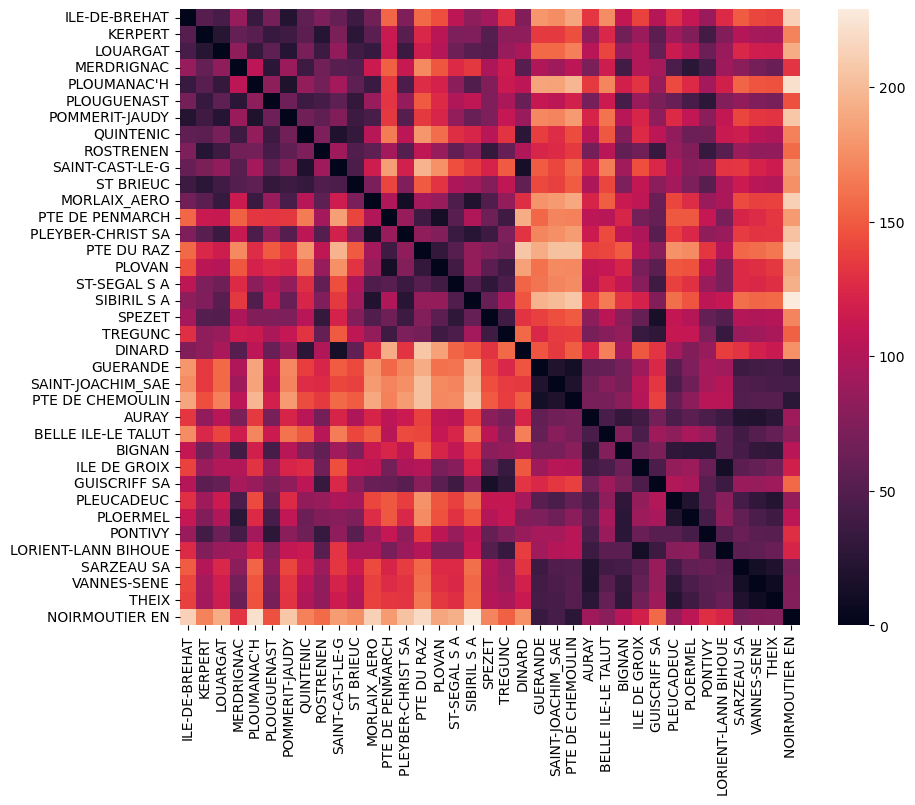

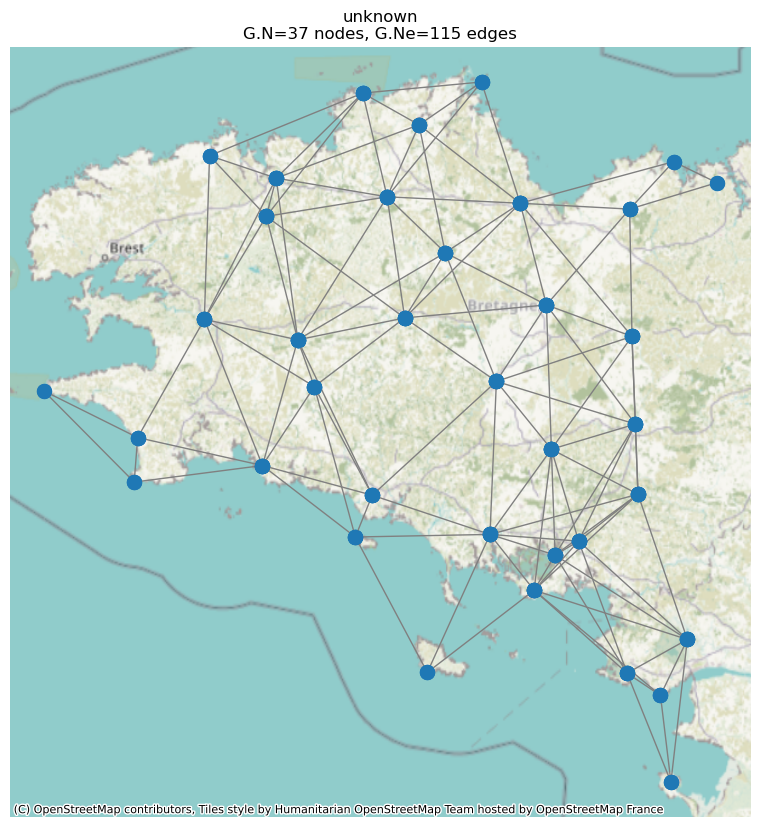

In [36]:
# USEFULL FUNCTIONS FROM LAST TUTORIAL
def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def is_connected(graph) -> bool:
    L = graph.L.todense()
    eigenvalues, _ = eigh(L)
    return (eigenvalues < 1e-6).sum() == 1

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

stations_np = stations_df_clean[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df_clean.Nom,
    yticklabels=stations_df_clean.Nom,
    ax=ax,
)

sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.74 #for 0.9 we have avg degree = 3.02
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G = graphs.Graph(adjacency_matrix_gaussian)
print(
    f"The graph is {'not ' if not is_connected(G) else ''}connected, with {G.N} nodes, {G.Ne} edges"
)

ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

print("average degree is : ", 2*G.Ne/G.N)
print("Threshold is : ", threshold)

Date with the most smooth signal: 2014-01-21 06:00:00


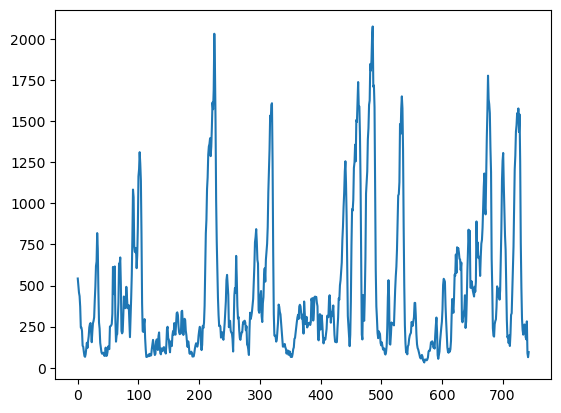

In [37]:
dates = pd.to_datetime(data_df_clean['date'])
L = G.L.todense()

all_smoothess = [row.T @ L @ row for _, row in temperature_df_clean.iterrows()]
plt.plot(all_smoothess)

#choosen_hour = pd.to_datetime("2014-01-02 01:00:00")
choosen_hour = dates[np.argmax(all_smoothess)]

#get time where np.nanargmin(all_smoothess)

#tmin = np.nanargmin(all_smoothess)
tmax = np.nanargmax(all_smoothess)
#get datetime for that index
#date_min = temperature_df_clean.index[tmin]
date_max = temperature_df_clean.index[tmax]
#print(f"Date with the least smooth signal: {date_min}")
print(f"Date with the most smooth signal: {date_max}")

Text(0.5, 1.0, 'Most smooth for 2014-01-21 06:00:00')

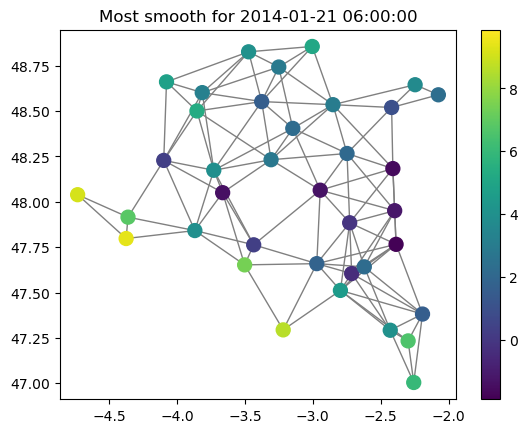

In [38]:
# Assuming 'choosen_hour' is the fixed time t
#choosen_hour = pd.to_datetime("2014-01-02 01:00:00")
all_smoothess = [row.T @ L @ row for _, row in temperature_df_clean.iterrows()]
dates = pd.to_datetime(data_df_clean['date'])
#choosen_hour = dates[np.argmax(all_smoothess)]
choosen_hour = pd.to_datetime("2014-01-21 06:00:00")
#print(choosen_hour)

# Filter the data to get the temperatures at the specified time
temp_at_t = data_df_clean[data_df_clean['date'] == choosen_hour][['station_name', 't']]

# Merge with station coordinates
stations_temp = stations_df_clean.merge(temp_at_t, left_on='Nom', right_on='station_name')

# Convert to GeoDataFrame
stations_temp_gdf_most = gpd.GeoDataFrame(
    stations_temp,
    geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
    crs=CRS
)

signal_most = np.array(stations_temp_gdf_most['t']) -273.15

G.plot_signal(np.array(stations_temp_gdf_most['t']) -273.15, vertex_size=100)
plt.title('Most smooth for '+ str(choosen_hour))

Text(0.5, 1.0, 'Least smooth for 2014-01-24 19:00:00')

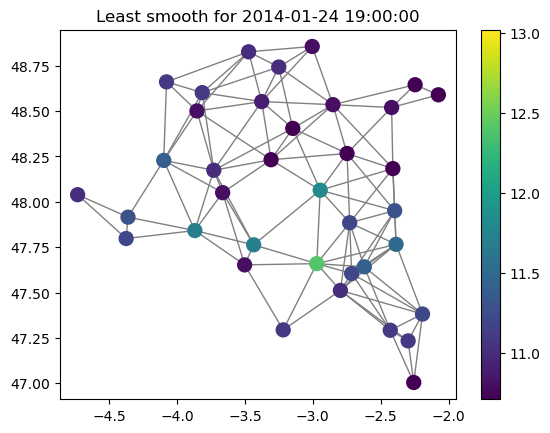

In [39]:
# Assuming 'choosen_hour' is the fixed time t
#choosen_hour = pd.to_datetime("2014-01-02 01:00:00")
all_smoothess = [row.T @ L @ row for _, row in temperature_df_clean.iterrows()]
dates = pd.to_datetime(data_df_clean['date'])
choosen_hour = temperature_df_clean.index[np.argmin(all_smoothess)]

# Filter the data to get the temperatures at the specified time
temp_at_t = data_df_clean[data_df_clean['date'] == choosen_hour][['station_name', 't']]

# Merge with station coordinates
stations_temp_least = stations_df_clean.merge(temp_at_t, left_on='Nom', right_on='station_name')

# Convert to GeoDataFrame
stations_temp_gdf_least = gpd.GeoDataFrame(
    stations_temp_least,
    geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
    crs=CRS
)

signal_least = np.array(stations_temp_gdf_least['t']) -273.15

G.plot_signal(np.array(stations_temp_gdf_least['t']) -273.15, vertex_size=100)
plt.title('Least smooth for '+ str(choosen_hour))

Text(0.5, 1.0, 'First timestamp 2014-01-01 00:00:00')

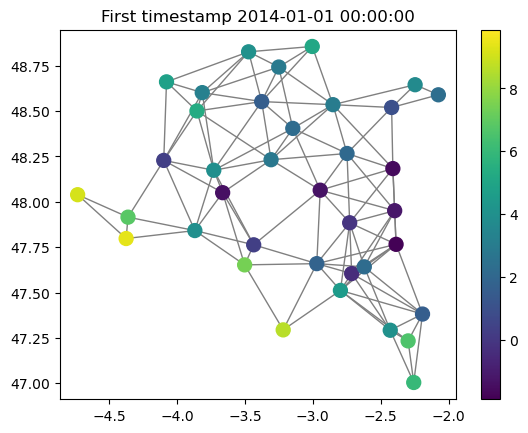

In [40]:
#first signal 
all_smoothess = [row.T @ L @ row for _, row in temperature_df_clean.iterrows()]
dates = pd.to_datetime(data_df_clean['date'])
#choosen_hour = dates[np.argmax(all_smoothess)]
choosen_hour = first_time = temperature_df_clean.index[0]

# Filter the data to get the temperatures at the specified time
temp_at_t = data_df_clean[data_df_clean['date'] == choosen_hour][['station_name', 't']]

# Merge with station coordinates
stations_temp_first = stations_df_clean.merge(temp_at_t, left_on='Nom', right_on='station_name')

# Convert to GeoDataFrame
stations_temp_gdf_first = gpd.GeoDataFrame(
    stations_temp_first,
    geometry=gpd.points_from_xy(stations_temp.Longitude, stations_temp.Latitude),
    crs=CRS
)

signal_first = np.array(stations_temp_gdf_first['t']) -273.15

G.plot_signal(np.array(stations_temp_gdf_most['t']) -273.15, vertex_size=100)
plt.title('First timestamp '+ str(choosen_hour))

# Question 5

<Figure size 640x480 with 0 Axes>

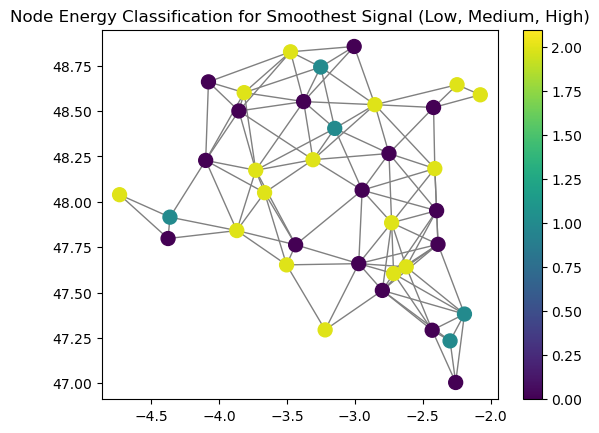

<Figure size 640x480 with 0 Axes>

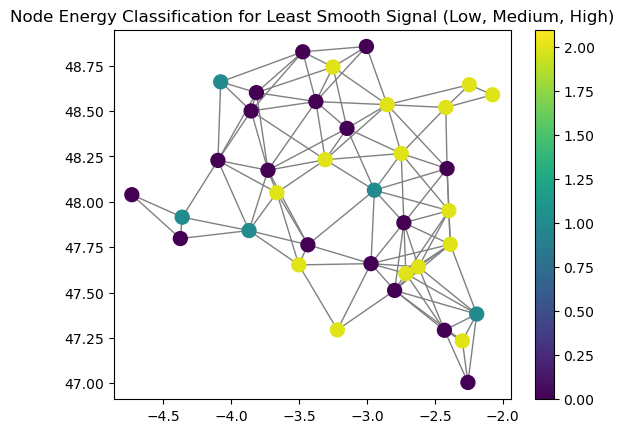

<Figure size 640x480 with 0 Axes>

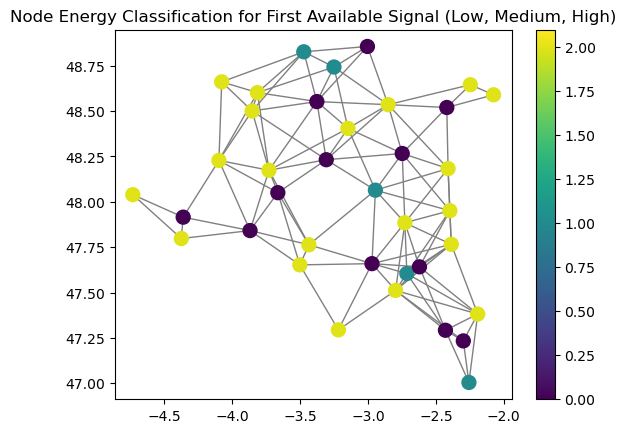

In [41]:
eigenvalues, eigenvectors = eigh(G.L.todense())
M=9
R=3
lambda_max = np.max(eigenvalues)
a = lambda_max/(M+1-R)

# Fourier transform of the signal
def get_fourier_transform(signal, graph):
    return graph.U.T @ signal

def get_wavelet_features_loop(signal, graph):
    signal_fourier = eigenvectors.T @ signal  # Shape: (N,)
    wavelet_features = np.zeros((M, graph.N))

    # Compute wavelet coefficients for all nodes and scales
    for m in range(1, M + 1):  
        wavelet_filter = g_hat_m(eigenvalues, m, a, R)  
        for node in range(graph.N):  # Iterate over nodes
            wavelet_features[m - 1, node] = np.sum(
                wavelet_filter * signal_fourier * eigenvectors[:, node]
            )
    return wavelet_features

# Classify nodes based on energy distribution across modes
def classify_nodes(signal, graph):
    # Get wavelet features
    wavelet_features = get_wavelet_features_loop(signal, graph)
    
    # Compute energy for each mode (low, medium, high)
    mode_energies = np.array([
        np.sum(wavelet_features[:3, :]**2, axis=0),  # Energy for low frequency (m=1,2,3)
        np.sum(wavelet_features[3:6, :]**2, axis=0),  # Energy for medium frequency (m=4,5,6)
        np.sum(wavelet_features[6:, :]**2, axis=0)    # Energy for high frequency (m=7,8,9)
    ])
    
    # Classify nodes by the mode with the highest energy
    classifications = np.argmax(mode_energies, axis=0)
    return classifications


# Example usage for the smoothest signal
smoothest_classifications = classify_nodes(signal_first, G)
least_smooth_classifications = classify_nodes(signal_least, G)
first_available_classifications = classify_nodes(signal_most, G)

# Define a mapping from classifications to colors
classification_colors = {
    0: 'blue',    # Low energy
    1: 'yellow',  # Medium energy
    2: 'red'      # High energy
}

for signal_name, classifications in zip(
    ['Smoothest', 'Least Smooth', 'First Available'],
    [smoothest_classifications, least_smooth_classifications, first_available_classifications]
):
    # Convert classifications to colors
    signal_colors = np.array([classification_colors[class_] for class_ in classifications])

    # Plot the graph with the assigned colors
    plt.figure()
    G.plot_signal(classifications, vertex_size=100)  # Removed colormap
    plt.title(f'Node Energy Classification for {signal_name} Signal (Low, Medium, High)')
    plt.show()


# Question 6

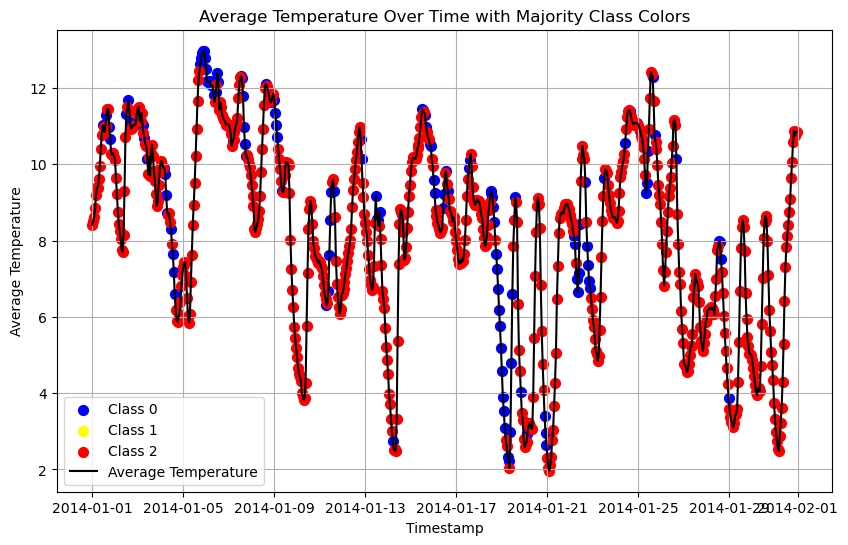

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute the average temperature and majority class for each timestamp
def compute_average_temperature_and_majority_class(temperature_df, graph):
    average_temperatures = []
    majority_classes = []

    for timestamp in temperature_df.index:
        # Get the signal (temperature) at the current timestamp
        signal = temperature_df.loc[timestamp].values

        # Classify nodes based on the signal
        classifications = classify_nodes(signal, graph)

        # Compute average temperature
        avg_temp = np.mean(signal)
        average_temperatures.append(avg_temp)

        # Determine the majority class
        unique, counts = np.unique(classifications, return_counts=True)
        majority_class = unique[np.argmax(counts)]
        majority_classes.append(majority_class)

    return average_temperatures, majority_classes

def plot_average_temperature_with_classes(temperature_df, average_temperatures, majority_classes):
    # Define colors for the majority classes
    class_colors = {0: 'blue', 1: 'yellow', 2: 'red'}
    class_labels = {0: 'Class 0', 1: 'Class 1', 2: 'Class 2'}

    # Create a figure
    plt.figure(figsize=(10, 6))
    
    # Plot points for each class separately to ensure proper legend
    for class_id, color in class_colors.items():
        class_indices = [i for i, majority_class in enumerate(majority_classes) if majority_class == class_id]
        plt.scatter(
            np.array(temperature_df.index)[class_indices],
            np.array(average_temperatures)[class_indices],
            color=color,
            label=class_labels[class_id],
            s=50
        )

    # Plot the average temperature line
    plt.plot(temperature_df.index, average_temperatures, color='black', label='Average Temperature')
    
    # Add title, labels, and legend
    plt.title("Average Temperature Over Time with Majority Class Colors")
    plt.xlabel("Timestamp")
    plt.ylabel("Average Temperature")
    plt.grid(True)
    plt.legend()
    plt.show()


# Example usage
average_temperatures, majority_classes = compute_average_temperature_and_majority_class(temperature_df_clean, G)
plot_average_temperature_with_classes(temperature_df_clean, average_temperatures, majority_classes)


# Question 7

In [43]:
from scipy.sparse import identity, kron

In [44]:
# Compute eigenvalues and eigenvectors of L_H using Kronecker properties
def compute_spatio_temporal_eigen(L_G, eigvals_G, eigvecs_G, L_G_prime, eigvals_G_prime, eigvecs_G_prime):
    # Eigenvalues of L_H are sums of Kronecker eigenvalues
    eigvals_H = np.add.outer(eigvals_G, eigvals_G_prime).flatten()

    # Eigenvectors of L_H are Kronecker products of the eigenvectors
    eigvecs_H = np.kron(eigvecs_G, eigvecs_G_prime)
    return eigvals_H, eigvecs_H


In [51]:
# Apply wavelet transform on the spatio-temporal graph
def get_wavelet_features_spatio_temporal(signal, eigvals_H, eigvecs_H, M, a, R):
    # Fourier transform of the signal
    print("eigvecs_H.shape", eigvecs_H.shape)
    print("signal.shape", signal.shape)
    # signal_fourier = get_fourier_transform(signal, eigvecs_H)  original
    signal_fourier = eigvecs_H @ signal # gregoire


    # Initialize wavelet features
    wavelet_features = np.zeros((M, eigvecs_H.shape[1]))

    # Compute wavelet coefficients for all nodes and scales
    for m in range(1, M + 1):
        wavelet_filter = g_hat_m(eigvals_H, m, a, R)
        wavelet_features[m - 1] = eigvecs_H @ (wavelet_filter * signal_fourier)
    return wavelet_features


In [52]:
# Classify nodes based on energy distribution
def classify_nodes_spatio_temporal(signal, eigvals_H, eigvecs_H, graph, M, a, R):
    wavelet_features = get_wavelet_features_spatio_temporal(signal, eigvals_H, eigvecs_H, M, a, R)

    # Compute energy for each mode
    mode_energies = np.array([
        np.sum(wavelet_features[:3, :]**2, axis=0),  # Low frequency
        np.sum(wavelet_features[3:6, :]**2, axis=0),  # Medium frequency
        np.sum(wavelet_features[6:, :]**2, axis=0)    # High frequency
    ])

    # Classify nodes by the mode with the highest energy
    classifications = np.argmax(mode_energies, axis=0)
    return classifications

# Visualize results
def plot_spatio_temporal_classifications(temperature_df, classifications, average_temperatures):
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature_df.index, average_temperatures, c=classifications, cmap='coolwarm', s=50)
    plt.title("Spatio-Temporal Classifications")
    plt.xlabel("Timestamp")
    plt.ylabel("Average Temperature")
    plt.colorbar(label="Class")
    plt.show()


In [156]:
eigenvec_time.shape, eigenvec_space.shape, f_hat.shape

((744, 744), (37, 37), (37, 744))

In [ ]:
# Compute the Laplacian matrix for the time dimension 
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """
    Return a line graph
    
    """
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph
L_time = get_line_graph(n_nodes=temperature_df_clean.index.size).L.todense()
In = np.eye(L_time.shape[0])

# Compute the Laplacian matrix for the space dimension 
L_space = G.L.todense()
Im = np.eye(L_space.shape[0])




# Compute the eigenvalues and eigenvectors of L_time and L_space
eigenval_time, eigenvec_time = scipy.linalg.eigh(L_time)
eigenval_space, eigenvec_space = scipy.linalg.eigh(L_space)

eigenval_time, eigenvec_time = eigh(L_time)
eigenval_space, eigenvec_space = eigh(L_space)
print('shape of eigenvec_time', eigenvec_time.shape)
print('shape of eigenvec_space', eigenvec_space.shape)
print('shape of f', f.shape)


# Compute the Graph Fourier Transform (GFT) using efficient einsum
# f = np.ravel(temperature_df.to_numpy(), order='F')  # Flatten the signal
# Compute the Graph Fourier Transform (GFT) using efficient einsum
f = temperature_df_clean.to_numpy()  # Signal with shape (n_space, n_time)

# f_hat = np.einsum("ki, lj, kl -> ij", eigenvectors, eigenvec_time, f.T)
f_hat = np.einsum("ki, ij, lj -> kl", eigenvec_space.T, f.T, eigenvec_time)
# Initialize variables for labels
M = 9
R = 3
labels = []
from tqdm import tqdm
count = 0 
# Compute the corresponding labels for each node
for v in tqdm(range(temperature_df_clean.shape[0])):  # Iterate over time
    W_v = []
    for m in range(1 , M+1):
        W = np.zeros_like(f[v])  # Placeholder for frequency coefficients
        count+=1
        for k, lambda_space in enumerate(eigenval_space):
            for l, lambda_time in enumerate(eigenval_time):
                lambda_comb = lambda_space * lambda_time
                g = g_hat_m(lambda_comb,eigenval_space[-1] * eigenval_time[-1],m, R )
                # W += g * f_hat[k, l] * eigenvec_space[v, k] * eigenvec_time[l, v] # original
                W += g * f_hat[k, l] 
        W_v.append(W)
    
    # Classify nodes into low/medium/high frequency
    val = [sum(np.abs(W_v[:3])**2), sum(np.abs(W_v[3:6])**2), sum(np.abs(W_v[6:])**2)]
    labels.append(np.argmax(val))



C:\Users\grego\AppData\Local\Temp\ipykernel_17680\2739670885.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0: Low', '', '', '', '1: Medium', '', '', '', '2: High'])


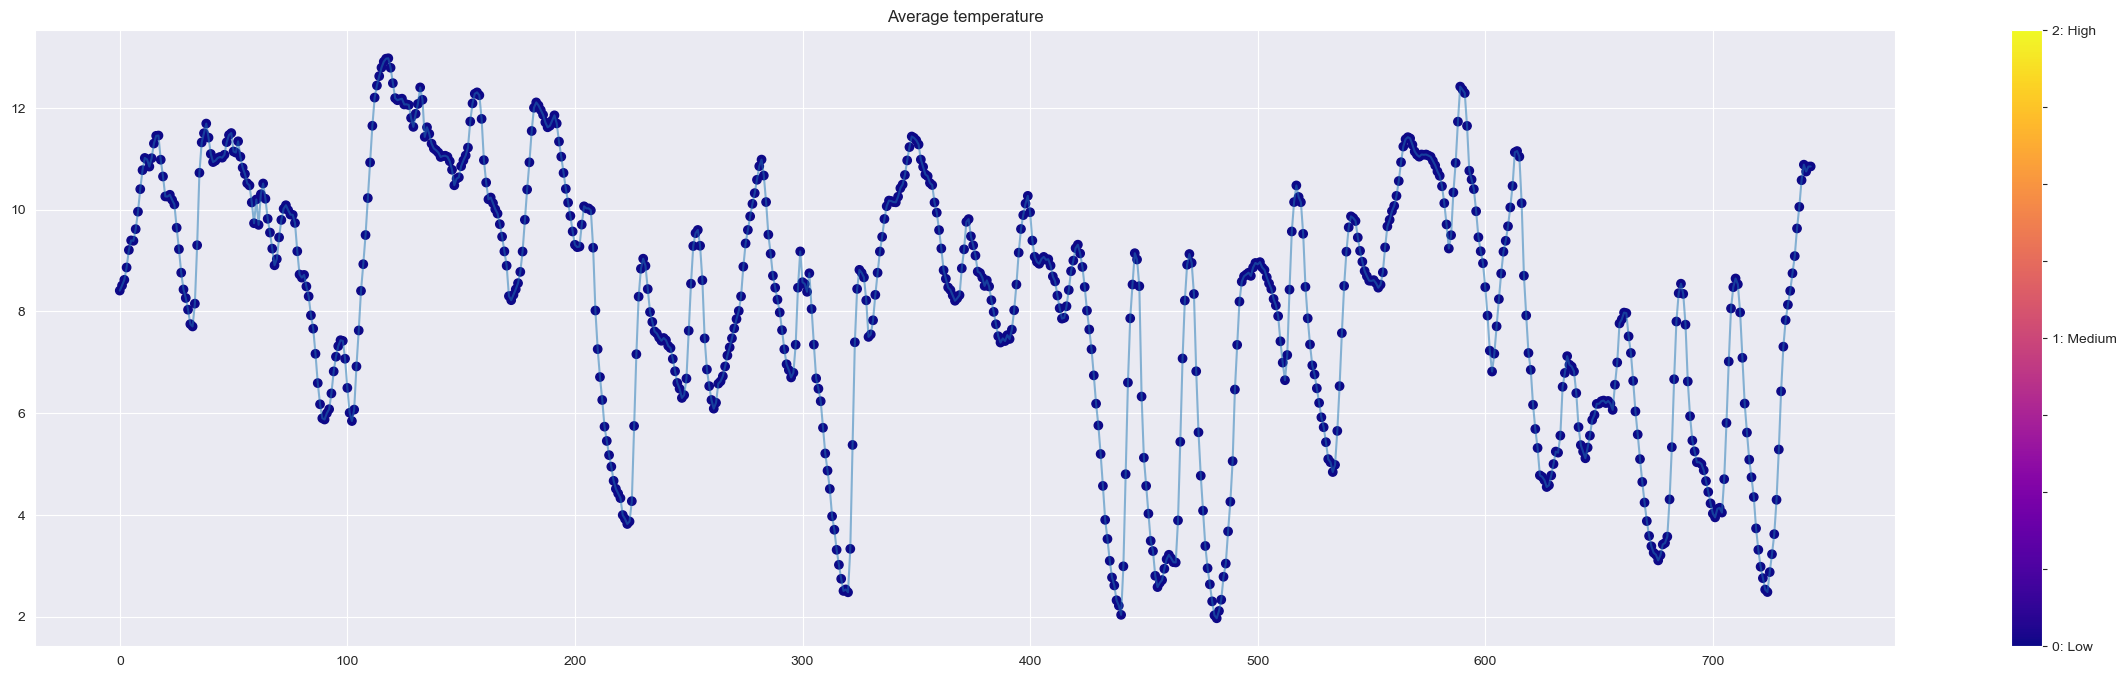

In [161]:

# # Adapt the marker colour to the majority class
# labels = np.reshape(np.array(labels), temperature_df_clean.shape)
# label_times = []
# for i in range(labels.shape[0]):
#     unique, counts = np.unique(labels[i], return_counts=True)
#     label_times.append(unique[np.argmax(counts)])

# Compute the average temperature
y = temperature_df_clean.mean(axis=1)
x = np.arange(y.shape[0])

# Display the average temperature for each timestamp with the adapted markers of the majority class
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(30, 8))
    plt.plot(x, y, alpha=0.5)
    plt.scatter(x, y, c=labels, cmap="plasma", vmin=0, vmax=2)
    cbar = plt.colorbar()
    plt.title('Average temperature')
    cbar.ax.set_yticklabels(['0: Low', '', '', '', '1: Medium', '', '', '', '2: High'])
    plt.show()


In [152]:
#laplacian of spatial graph
L_G = G.L.todense()
eigvals_G, eigvecs_G = eigh(L_G)
#laplacian of temporal graph : line graph without loop
# define the line graph
adjacency_line = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) 
L_G_prime = graphs.Graph(adjacency_line).L.todense()
eigvals_G_prime, eigvecs_G_prime = eigh(L_G_prime)

num_timesteps = len(temperature_df_clean.index)

#L_H = compute_spatio_temporal_laplacian(L_G, L_G_prime, num_timesteps)
eigvals_H, eigvecs_H = compute_spatio_temporal_eigen(L_G, eigvals_G, eigvecs_G, L_G_prime, eigvals_G_prime, eigvecs_G_prime)
classifications = classify_nodes_spatio_temporal(signal, eigvals_H, eigvecs_H, G, M, a, R)
plot_spatio_temporal_classifications(temperature_df_clean, classifications, average_temperatures)

(36, 743, 9, 36)

BROUILLON :

In [ ]:

# # Compute the eigenvalues and eigenvectors of the cartesian product of the previous graphs 
# eigenval_time, eigenvec_time = scipy.linalg.eig(L_time)
# eigenval_space, eigenvec_space = scipy.linalg.eig(L_space)
# eigenval_time = eigenval_time.real
# eigenval_space = eigenval_space.real

# shape = L_time.shape[0] * L_space.shape[0]
# eigenval = np.zeros(shape) 
# for i in range(eigenval_time.shape[0]) :
#   for j in range(eigenval_space.shape[0]) :
#     eigenval[eigenval_space.shape[0]*i+j] = eigenval_time[i] + eigenval_space[j]

# eigenvec = np.zeros((shape,shape))
# for i in range(eigenval_time.shape[0]) :
#   for j in range(eigenval_space.shape[0]) :
#      eigenvec[:,eigenval_space.shape[0]*i+j] = np.kron(eigenvec_time[:,i], eigenvec_space[:,j])

# # Sort eigenvalues and eigenvectors 
# idx = eigenval.argsort()
# eigenval = eigenval[idx]
# eigenvec = eigenvec[:, idx]

# # Compute the Graph Fourrier Transform (GFT) of the graph signal "f"
# f = np.ravel(temperature_df.to_numpy(), order='F')
# print("Shape of eigenvec.T:", eigenvec.T.shape)
# print("Shape of f:", f.shape)
# f_hat = eigenvec.T @ f 

# M = 9
# R = 3

# # Compute the corresponding labels
# labels = []
# for v in tqdm(range(len(f))):
#   W_v =[]
#   for m in range(1,M+1):
#     W = 0
#     for i in range(len(eigenval)) :
#       W += g_m(eigenval[i], R, m, lambdn=eigenval[-1]) * f_hat[i] * eigenvec[v,i]
#     W_v.append(W)
  
#   # Classify nodes into low/medium/high frequency
#   val = [sum(np.abs(W_v[:3])**2),sum(np.abs(W_v[3:6])**2),sum(np.abs(W_v[6:])**2)]
#   labels.append(np.argmax(val))

# # Adapt the marker colour to the majority class
# labels = np.reshape(np.array(labels),temperature_df.shape)
# label_times = []
# for i in range(labels.shape[0]):
#   unique, counts = np.unique(labels[i], return_counts=True)
#   label_times.append(unique[np.argmax(counts)])

# # Compute the average temperature
# y = temperature_df.mean(axis=1)
# x = np.arange(y.shape[0])

# # Display the average temperature for each timestamp with the adapted markers of the majority class
# with sns.axes_style('darkgrid'):
#   plt.figure(figsize=(30, 8))
#   plt.plot(x, y, alpha=0.5)
#   plt.scatter(x, y, c=label_times,cmap="plasma", vmin= 0 , vmax=2)
#   cbar = plt.colorbar()
#   plt.title('Average temperature')
#   cbar.ax.set_yticklabels(['0: Low','','','','1:Medium','','','','2: High'])
#   plt.show()

### ESSAIS QUESTION 1 

In [ ]:
import numpy as np
import ruptures as rpt
from scipy.signal import spectrogram
import time

threshold_pixel = 0.0001
threshold_mean_occup, threshold_mean_empty = 0.7, 0.4

def get_change_point_and_freq_unknown_K(signal, symbols, threshold_diff_freq_symb = 500, threshold_diff_freq_silences = 400, threshold_symbols=0.9, threshold_silences=0.25):
    # Compute spectrogram
    print("real K = ", 2*len(symbols)) 
    f, t, Sxx = scipy.signal.stft(signal, fs=FS, noverlap=100, nperseg=312,padded=True)

    # Select a specific frequency band or summarize
    freq_band = (500, 2000)  # Focus on 500-2000 Hz
    freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
    spectrogram_band = np.abs(Sxx[freq_mask, :])  # Select power in the frequency band
   
    #f, t, Sxx = spectrogram(signal, fs=FS)
    #Sxx = np.log10(Sxx + 1e-10)
    #threshold_pixel = np.percentile(Sxx, 90) # Log scaling to reduce noise (avoid log(0) with epsilon)

    # Select the frequency band 500–2000 Hz
    #freq_band = (500, 2000)
    #freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
    #spectrogram_band = Sxx[freq_mask, :]  # Focused frequency band
    frequencies = f[freq_mask]

    # Noise reduction: compute dominant frequency for each time step
    spectro = np.zeros(spectrogram_band.shape[1])  # 1D clean signal for segmentation
    spec_reduced = np.zeros((3, spectrogram_band.shape[1]))  # Top 3 frequencies

    for i in range(spectrogram_band.shape[1]):  # Iterate over time steps
        # Find top 3 frequencies with the highest power
        top_indices = np.argpartition(spectrogram_band[:, i], -3)[-3:]
        top_indices = np.sort(top_indices)  # Sort indices for consistency

        # Weighted average of the top 3 frequencies
        spectro[i] = np.average(frequencies[top_indices], weights=spectrogram_band[top_indices, i])

        # Store the top 3 frequencies
        spec_reduced[:, i] = frequencies[top_indices]

        # Adaptive threshold
    threshold_pixel = np.percentile(spectrogram_band, 90) * 0.1

    # Initialize good breakpoints search
    good_n_bkps = False
    n_bkps = 3
    while not good_n_bkps:
        print(f'> Currently trying for n_bkps={n_bkps} !')

        symbols_detected, silence_detected = [], []
        diff_freq_symb, diff_freq_silence = [], []

        algo = rpt.Dynp(model="l2", jump=1).fit(spectro)
        predicted_bkps = algo.predict(n_bkps=n_bkps)

        for i in range(len(predicted_bkps) - 1):
            start_idx, end_idx = predicted_bkps[i], predicted_bkps[i + 1]
            
            # Skip small segments
            if end_idx - start_idx < 10:
                continue
            
            segment = spectrogram_band[:, start_idx:end_idx]
            mean_powers = np.mean(segment, axis=1)
            
            top_indices = np.argsort(mean_powers)[-2:]
            top_frequencies = np.sort(frequencies[top_indices])
            top_powers = mean_powers[top_indices]

            weighted_diff = np.abs(top_frequencies[1] - top_frequencies[0]) * (top_powers[1] / np.sum(top_powers))
            
            if i % 2 == 0:  # Symbols
                symbols_detected.append(np.mean(segment[top_indices[-1], :] > threshold_pixel))
                diff_freq_symb.append(weighted_diff)
            else:  # Silence
                silence_detected.append(np.mean(segment[top_indices[-1], :] > threshold_pixel))
                diff_freq_silence.append(weighted_diff)
        
        mean_symbols = np.mean(symbols_detected) if symbols_detected else 0
        mean_silence = np.mean(silence_detected) if silence_detected else 0

        print(f'  >> Mean symbols: {mean_symbols:.2f} - Mean silence: {mean_silence:.2f}')

        if (np.array(diff_freq_symb) > np.mean(diff_freq_symb) + np.std(diff_freq_symb)).all() and \
        (np.array(diff_freq_silence) < np.mean(diff_freq_silence) - np.std(diff_freq_silence)).all():
            print(f'Optimal number found: {n_bkps}!')
            good_n_bkps = True
        else:
            n_bkps += 1


    # Return breakpoints and reduced spectrogram frequencies
    return [t[cp] for cp in predicted_bkps if cp < len(t)], res_freq


In [ ]:
import numpy as np
import ruptures as rpt
from scipy.signal import spectrogram
import time

threshold_pixel = 0.0001
threshold_mean_occup, threshold_mean_empty = 0.7, 0.4

def get_change_point_and_freq_unknown_K(signal, symbols, threshold_diff_freq_symb = 500, threshold_diff_freq_silences = 400, threshold_symbols=0.9, threshold_silences=0.25):
    # Compute spectrogram
    print("real K = ", 2*len(symbols)) 
    f, t, Sxx = scipy.signal.stft(signal, fs=FS, noverlap=100, nperseg=312,padded=True)

    # Select a specific frequency band or summarize
    freq_band = (500, 2000)  # Focus on 500-2000 Hz
    freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
    spectrogram_band = np.abs(Sxx[freq_mask, :])  # Select power in the frequency band
   
    #f, t, Sxx = spectrogram(signal, fs=FS)
    #Sxx = np.log10(Sxx + 1e-10)
    #threshold_pixel = np.percentile(Sxx, 90) # Log scaling to reduce noise (avoid log(0) with epsilon)

    # Select the frequency band 500–2000 Hz
    #freq_band = (500, 2000)
    #freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
    #spectrogram_band = Sxx[freq_mask, :]  # Focused frequency band
    frequencies = f[freq_mask]
    
    time_series = np.mean(spectrogram_band, axis=0)

    # Initialize while loop for optimal n_bkps
    good_n_bkps = False
    n_bkps = 3  # Start with 3 breakpoints
    n_bkps_to_try = np.array([2*k for k in range(2, 13)])
    mean_occupation_all = []

    start_time = time.time()

    # iterate over values to try for n_bkps
    
    for n_bkps in n_bkps_to_try:
        print(f'> Currently trying for n_bkps={n_bkps} !')
        symbols_detected, silence_detected, res_freq = [], [], []
        diff_freq_symb, diff_freq_silence = [], []

        # Fit the Dynp model on the clean spectrogram signal
        algo = rpt.Dynp(model="l2", jump=1).fit(time_series)
        predicted_bkps = algo.predict(n_bkps=n_bkps)

        # Iterate over predicted segments
        for i in range(0, len(predicted_bkps) - 1):  # Exclude last segment
            start_idx, end_idx = predicted_bkps[i], predicted_bkps[i + 1]

            # Extract segment from the original spectrogram band
            segment = spectrogram_band[:, start_idx:end_idx]
            mean_powers = np.mean(segment, axis=1)

            # Top 2 frequencies for the segment
            top_indices = np.argsort(mean_powers)[-2:]
            top_frequencies = np.sort(frequencies[top_indices])
            
            # Find dominant frequency index and compute mean occupation
            max_freq_idx = np.argmax(mean_powers)
            mean_prominent = np.mean(segment[max_freq_idx, :] > threshold_pixel)

            # Separate symbol and silence segments
            if i % 2 == 0:  # Symbols
                symbols_detected.append(mean_prominent)
                res_freq.append(top_frequencies)
                diff_freq_symb.append(top_frequencies[1] - top_frequencies[0])
                
                print(f"top freqs symb= {top_frequencies}")
            else:  # Silence
                silence_detected.append(mean_prominent)
                diff_freq_silence.append(top_frequencies[1] - top_frequencies[0])
                print(f"top freqs bruit= {top_frequencies}")

        # Compute overall mean for symbols and silences
        mean_symbols = np.mean(symbols_detected) if symbols_detected else 0
        mean_silence = np.mean(silence_detected) if silence_detected else 0

        print(f'  >> Mean symbols: {mean_symbols:.2f} - Mean silence: {mean_silence:.2f}')

        # Check thresholds
        #if (mean_symbols > threshold_mean_occup) and (mean_silence < threshold_mean_empty):
        if (np.array(diff_freq_symb) > threshold_diff_freq_symb).all() and (np.array(diff_freq_silence) < threshold_diff_freq_silences).all():
            exec_time = time.time() - start_time
            print(f'Optimal number found: {n_bkps}! Execution time: {exec_time:.2f} seconds')
            break  # Break the loop

    # Return breakpoints and reduced spectrogram frequencies
    return [t[cp] for cp in predicted_bkps if cp < len(t)], res_freq


In [ ]:
import numpy as np
import ruptures as rpt
from scipy.signal import spectrogram
import time

threshold_pixel = 0.0001
threshold_mean_occup, threshold_mean_empty = 0.7, 0.4

def get_change_point_and_freq_unknown_K(signal, symbols, threshold_diff_freq_symb = 500, threshold_diff_freq_silences = 400, threshold_symbols=0.9, threshold_silences=0.25):
    # Compute spectrogram
    print("real K = ", 2*len(symbols)) 
    f, t, Sxx = scipy.signal.stft(signal, fs=FS, noverlap=100, nperseg=312,padded=True)

    # Select a specific frequency band or summarize
    freq_band = (500, 2000)  # Focus on 500-2000 Hz
    freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
    spectrogram_band = np.abs(Sxx[freq_mask, :])  # Select power in the frequency band
   
    #f, t, Sxx = spectrogram(signal, fs=FS)
    #Sxx = np.log10(Sxx + 1e-10)
    #threshold_pixel = np.percentile(Sxx, 90) # Log scaling to reduce noise (avoid log(0) with epsilon)

    # Select the frequency band 500–2000 Hz
    #freq_band = (500, 2000)
    #freq_mask = (f >= freq_band[0]) & (f <= freq_band[1])
    #spectrogram_band = Sxx[freq_mask, :]  # Focused frequency band
    frequencies = f[freq_mask]
    
    time_series = np.mean(spectrogram_band, axis=0)

    # Initialize while loop for optimal n_bkps
    good_n_bkps = False
    n_bkps = 3  # Start with 3 breakpoints
    n_bkps_to_try = np.array([2*k for k in range(2, 13)])
    mean_occupation_all = []

    start_time = time.time()

    # iterate over values to try for n_bkps
    
    for n_bkps in n_bkps_to_try:
        print(f'> Currently trying for n_bkps={n_bkps} !')
        symbols_detected, silence_detected, res_freq = [], [], []
        diff_freq_symb, diff_freq_silence = [], []

        # Fit the Dynp model on the clean spectrogram signal
        algo = rpt.Dynp(model="l2", jump=1).fit(spectrogram_band)
        predicted_bkps = algo.predict(n_bkps=n_bkps)

        # Iterate over predicted segments
        for i in range(0, len(predicted_bkps) - 1):  # Exclude last segment
            start_idx, end_idx = predicted_bkps[i], predicted_bkps[i + 1]

            # Extract segment from the original spectrogram band
            segment = spectrogram_band[:, start_idx:end_idx]
            mean_powers = np.mean(segment, axis=1)

            # Top 2 frequencies for the segment
            top_indices = np.argsort(mean_powers)[-2:]
            top_frequencies = np.sort(frequencies[top_indices])
            
            # Find dominant frequency index and compute mean occupation
            max_freq_idx = np.argmax(mean_powers)
            mean_prominent = np.mean(segment[max_freq_idx, :] > threshold_pixel)

            # Separate symbol and silence segments
            if i % 2 == 0:  # Symbols
                symbols_detected.append(mean_prominent)
                res_freq.append(top_frequencies)
                diff_freq_symb.append(top_frequencies[1] - top_frequencies[0])
                
                print(f"top freqs symb= {top_frequencies}")
            else:  # Silence
                silence_detected.append(mean_prominent)
                diff_freq_silence.append(top_frequencies[1] - top_frequencies[0])
                print(f"top freqs bruit= {top_frequencies}")

        # Compute overall mean for symbols and silences
        mean_symbols = np.mean(symbols_detected) if symbols_detected else 0
        mean_silence = np.mean(silence_detected) if silence_detected else 0

        print(f'  >> Mean symbols: {mean_symbols:.2f} - Mean silence: {mean_silence:.2f}')

        # Check thresholds
        #if (mean_symbols > threshold_mean_occup) and (mean_silence < threshold_mean_empty):
        if (np.array(diff_freq_symb) > threshold_diff_freq_symb).all() and (np.array(diff_freq_silence) < threshold_diff_freq_silences).all():
            exec_time = time.time() - start_time
            print(f'Optimal number found: {n_bkps}! Execution time: {exec_time:.2f} seconds')
            break  # Break the loop

    # Return breakpoints and reduced spectrogram frequencies
    return [t[cp] for cp in predicted_bkps if cp < len(t)], res_freq
